In [1]:
# Import libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats

In [2]:
# Load settings
TECH = 'B'
with open(f"data/tech{TECH}/settings.json") as sfile:
    settings = json.load(sfile)

# Load data for technology
colnames = ["addr", "time", "r", "g", "gi", "range", "timept"]
data = pd.read_csv(f"data/tech{TECH}/relaxdata.min.tsv.gz", names=colnames, sep='\t')

In [3]:
# Binary mapping
Dict_2bit = {0: '00', 1: '01', 2: '11', 3: '10'}

In [6]:
# Letters
def diff_letters(a,b):
    results = []
    for i in range(len(a)):
        if a[i] != b[i]:
            results.append(i)
    return results

In [7]:
# Array error calculation
def error_array_calculation_2(index):
    data = pd.read_csv(f"data/tech{TECH}/relaxdata.min.tsv.gz", names=colnames, sep='\t')
    symbol_error_array = np.zeros((len(index),len(index)))
    bits = int(np.log2(len(index)))
    page_error_array = np.zeros(bits)
    threshold = np.zeros(5)
    threshold[-1] = 300
    for k in range(len(index)-1):
        rdata_left = data[(data["range"] == index[k]) & (data["timept"] == 1e5)]["g"]*1e6
        rdata_right = data[(data["range"] == index[k+1]) & (data["timept"] == 1e5)]["g"]*1e6
        gx = np.linspace(0, settings["gmax"]*1.1e6, 500)
        pdf_left = scipy.stats.gaussian_kde(rdata_left).pdf(gx)
        pdf_right = scipy.stats.gaussian_kde(rdata_right).pdf(gx)
        intersection = np.argmax((1-np.abs(pdf_left-pdf_right))*(gx>np.median(rdata_left))*(gx<np.median(rdata_right)))
        threshold[k+1] = gx[intersection]
    for k in range(len(index)):
        rdata = data[(data["range"] == index[k]) & (data["timept"] == 1e5)]["g"]*1e6
        for kk in range(len(index)):
            if k == kk:
                continue
            else:
                symbol_error_array[k,kk] = np.sum((rdata<threshold[kk+1]) * (rdata>threshold[kk]))/len(rdata)
                bits_difference = diff_letters(Dict_2bit[k],Dict_2bit[kk])
                for bit in bits_difference:
                    page_error_array[bit] += symbol_error_array[k,kk]/len(index)    
    return symbol_error_array, page_error_array, threshold

In [8]:
# Find best combinations
from itertools import combinations
symbol_error_array_min = 100
page_error_array_min = 100
index_min_1 = index_min_2 = np.zeros(4)
comb = combinations(np.arange(30)+1, 2)
i_sum = 0
index = np.array([0,0,0,31])
for i in list(comb):
    index[1] = i[0]
    index[2] = i[1]
    i_sum += 1
    if i_sum % 100 == 0:
        print(i_sum)
    symbol_error_array, page_error_array, _ = error_array_calculation_2(index)
#    if np.mean(symbol_error_array)<symbol_error_array_min:
#        symbol_error_array_min = np.mean(symbol_error_array)
#        index_min_1 = index.copy()
    if np.max(page_error_array)<page_error_array_min:
        page_error_array_min = np.max(page_error_array)
        index_min_2 = index.copy()    
        print(page_error_array_min)

/home/users/xzheng3/.local/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


0.22849888684656328
0.19769618863589938
0.1976836063937896
0.19368817260383525
0.16777308129059249
0.10787326092283692
0.09487470201755915
0.08443297529803875
0.06418880600577327
0.046812326593221716
0.04320810934037387
0.03484921238916673
0.032185792265458056
0.0283545939938634
100
0.0216087740011185
0.019974760013240646
0.01790949977683936
0.010677991742113003
0.010065814943863724
0.006649124296183119
0.006141186766711535
0.004944564646057184
0.0034485590740838427
200
300
400


In [9]:
symbol_error_array, page_error_array, threshold = error_array_calculation_2(index_min_2)

/home/users/xzheng3/.local/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [10]:
print(index_min_2)
print(threshold)

[ 0  7 23 31]
[  0.          11.56873747  61.22965932 110.32625251 300.        ]


/home/users/xzheng3/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 181 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/users/xzheng3/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 181 missing from current font.
  font.set_text(s, 0, flags=flags)


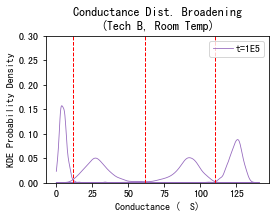

In [11]:
ranges = index_min_2
data = pd.read_csv(f"data/tech{TECH}/relaxdata.min.tsv.gz", names=colnames, sep='\t')
# Conductance broadening behavior
fig = plt.figure(figsize=(4, 2.7))
ax = fig.add_subplot(111)
ax.set_title(f"Conductance Dist. Broadening\n(Tech {TECH}, Room Temp)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for time, color in zip(settings["times"], colors):
    if time == 1e5:
        for r in ranges:
            gx = np.linspace(0, settings["gmax"]*1.1e6, 500)
            gvals = data[(data["range"] == r) & (data["timept"] == 1e5)]["g"]
            pdf = scipy.stats.gaussian_kde(gvals*1e6).pdf(gx)
            label = (f"t={time}" if time < 100 else f"t=1E{int(np.log10(time))}") if r == 0 else None
            plt.plot(gx, pdf, color=color, label=label, linewidth=0.8)
for tick in threshold[1:-1]:
    plt.axvline(tick, color='red', linestyle='--', linewidth=1, alpha=1)
ax.legend(ncol=3, handletextpad=0.2)
ax.set_ylim(*settings["gbroad_ylim"])
ax.set_xlabel("Conductance (µS)")
ax.set_ylabel("KDE Probability Density")
plt.show()

In [12]:
dota_teams = Dict_2bit.values()
data = np.round_(symbol_error_array*100, decimals = 1).tolist()
format_row = "{:>7}" * (len(dota_teams) + 1)
print(format_row.format("", *dota_teams))
for team, row in zip(dota_teams, data):
    print(format_row.format(team, *row))

            00     01     11     10
     00    0.0    0.9    0.0    0.0
     01    0.2    0.0    0.2    0.0
     11    0.0    1.0    0.0    0.0
     10    0.0    0.0    0.3    0.0


In [13]:
print(page_error_array)

[0.00321842 0.00344856]
